
# Fresnel Zones and Sensitivity (GNSS‑IR)

This notebook extends the geometric foundation to quantify the **sensitivity footprint** of GNSS‑IR using Fresnel‑zone concepts.
We derive practical expressions for the first Fresnel radius, explore how it scales with elevation angle and wavelength,
and visualize the **reflection footprint** around the specular point.

**You will:**
- Derive and use the first Fresnel‑zone radius $r_1$ for GNSS‑IR.
- Understand scaling with antenna height $h$, wavelength $\lambda$, and elevation $E$.
- Visualize Fresnel rings on the ground around the specular point.
- Explore implications for environmental sensing (snow, soil moisture, water level).



## Derivation (flat reflector, far‑field)

Consider the two‑ray geometry from the previous notebooks. Near the **specular point**,
the **path‑length difference** between the direct and reflected rays is (plane‑wave, flat reflector)
$$
\Delta L(E) \approx 2h\sin E.
$$
Perturbations for a nearby ground point at lateral offset $r$ introduce an **extra** path difference.
The **first Fresnel zone** is defined as the set of points for which the additional phase is within $\pi$ (i.e., added path $\lesssim \lambda/2$).

Under standard approximations for a monostatic two‑ray configuration, one obtains the widely used practical form
$$
\boxed{ \ r_1(E) \;\approx\; \sqrt{\frac{\lambda\,h}{2\,\sin E}}\ }.
$$
This captures the correct trends:
- $r_1 \propto \sqrt{\lambda}$: longer wavelengths average over larger footprints.
- $r_1 \propto \sqrt{h}$: taller antennas increase the footprint size.
- $r_1 \propto 1/\sqrt{\sin E}$: lower elevation (grazing) increases the footprint.



> **Notes & assumptions**
> - Locally **flat** reflector, small‑slope, far‑field (plane‑wave) satellite.
> - No azimuthal anisotropy from surface roughness; rings are drawn as circles centered at the **specular point**.
> - This is an **intuitive, practical** expression used in GNSS‑IR literature; exact coefficients can vary among derivations.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Physical constants / GNSS wavelengths (m)
c = 299792458.0
f_L1 = 1575.42e6
f_L2 = 1227.60e6
f_L5 = 1176.45e6
lambda_L1 = c / f_L1
lambda_L2 = c / f_L2
lambda_L5 = c / f_L5

lambda_L1, lambda_L2, lambda_L5


(0.19029367279836487, 0.24421021342456825, 0.25482804879085386)


## First Fresnel Radius Function and Scaling
We'll implement $ r_1(E) = \sqrt{\dfrac{\lambda h}{2\sin E}} $ and examine its dependence on $E, h, \lambda$.


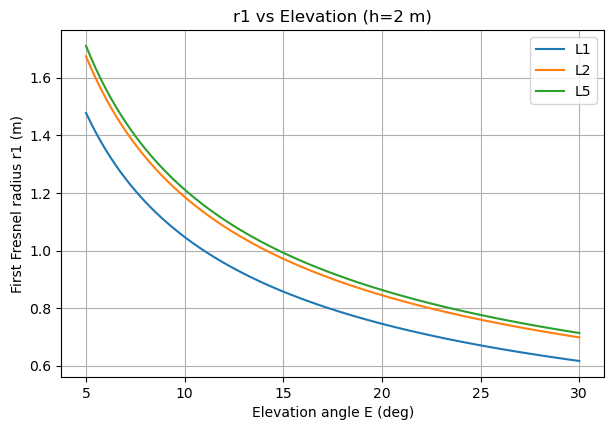

In [2]:

def r1_fresnel(h, elev_deg, wavelength):
    E = np.deg2rad(elev_deg)
    return np.sqrt((wavelength * h) / (2.0 * np.sin(E)))

E_grid = np.linspace(5, 30, 200)  # typical GNSS-IR elevation window
h_demo = 2.0
r1_L1 = r1_fresnel(h_demo, E_grid, lambda_L1)
r1_L2 = r1_fresnel(h_demo, E_grid, lambda_L2)
r1_L5 = r1_fresnel(h_demo, E_grid, lambda_L5)

plt.figure(figsize=(7,4.5))
plt.plot(E_grid, r1_L1, label='L1')
plt.plot(E_grid, r1_L2, label='L2')
plt.plot(E_grid, r1_L5, label='L5')
plt.xlabel('Elevation angle E (deg)')
plt.ylabel('First Fresnel radius r1 (m)')
plt.title('r1 vs Elevation (h=2 m)')
plt.grid(True)
plt.legend()
plt.show()


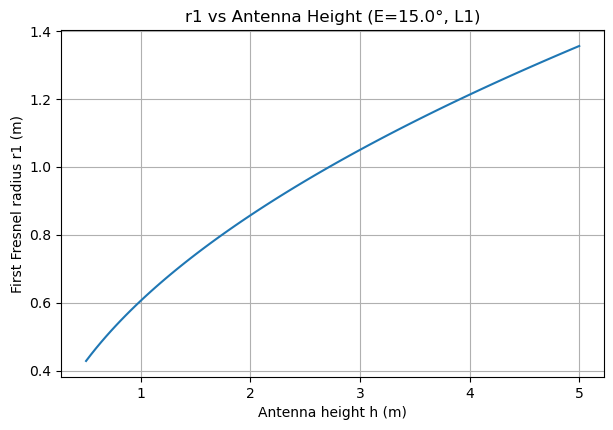

In [3]:

# r1 vs antenna height at fixed elevation
E_fix = 15.0
h_vals = np.linspace(0.5, 5.0, 100)
r1_vs_h = r1_fresnel(h_vals, E_fix, lambda_L1)

plt.figure(figsize=(7,4.5))
plt.plot(h_vals, r1_vs_h)
plt.xlabel('Antenna height h (m)')
plt.ylabel('First Fresnel radius r1 (m)')
plt.title(f'r1 vs Antenna Height (E={E_fix}°, L1)')
plt.grid(True)
plt.show()



## Ground Footprint Visualization

We now draw **Fresnel rings** around the **specular point**. From the previous notebook,
the specular point is at horizontal offset $r = h\cot E$ from the antenna, in the azimuth direction $A$.  
For simplicity, we'll set $A=0^\circ$ (north) so the specular point lies on the $+y$ axis at $(x,y)=(0, r)$.


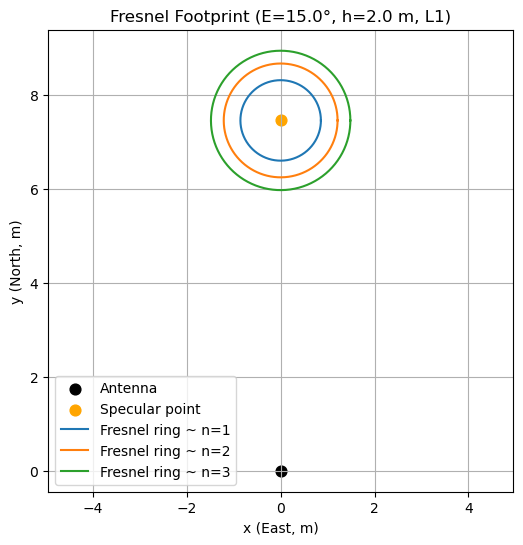

In [4]:

def specular_point(h, elev_deg, azimuth_deg):
    E = np.deg2rad(elev_deg)
    A = np.deg2rad(azimuth_deg)
    r = h / np.tan(E)  # horizontal offset
    x = r * np.sin(A)
    y = r * np.cos(A)
    return x, y, r

# Choose geometry
h0 = 2.0
E0 = 15.0
A0 = 0.0
xP, yP, r_off = specular_point(h0, E0, A0)

# Fresnel rings radii (first few)
wavelength = lambda_L1
r1 = r1_fresnel(h0, E0, wavelength)
radii = [r1, np.sqrt(2)*r1, np.sqrt(3)*r1]  # simple ring scaling for illustration

# Draw
theta = np.linspace(0, 2*np.pi, 400)
plt.figure(figsize=(6,6))
plt.scatter(0, 0, s=60, color='k', label='Antenna')
plt.scatter(xP, yP, s=60, color='orange', label='Specular point')

for k, R in enumerate(radii, start=1):
    plt.plot(xP + R*np.cos(theta), yP + R*np.sin(theta), label=f'Fresnel ring ~ n={k}')

plt.axis('equal')
plt.xlabel('x (East, m)')
plt.ylabel('y (North, m)')
plt.title(f'Fresnel Footprint (E={E0}°, h={h0} m, L1)')
plt.grid(True)
plt.legend()
plt.show()



### Interpreting the footprint
- Lower elevation ⇒ larger \(r_1\) ⇒ broader spatial averaging (more sensitivity to mesoscale variations, less to fine structure).
- Shorter wavelength (e.g., L5) **reduces** \(r_1\) slightly compared to L1.
- Taller antenna increases \(r_1\), widening the sensitivity area.



## A Simple Sensitivity Kernel (Proxy)

While the true GNSS‑IR sensitivity kernel depends on geometry, polarization, and surface properties,
a useful **proxy** is a smooth radial weighting centered at the specular point that decays with distance,
e.g., a Gaussian with standard deviation tied to $r_1$. This is only for **intuition/visualization**.

We set $\sigma = r_1/\sqrt{2}$ so that the radius $r_1$ is near the half‑power contour.


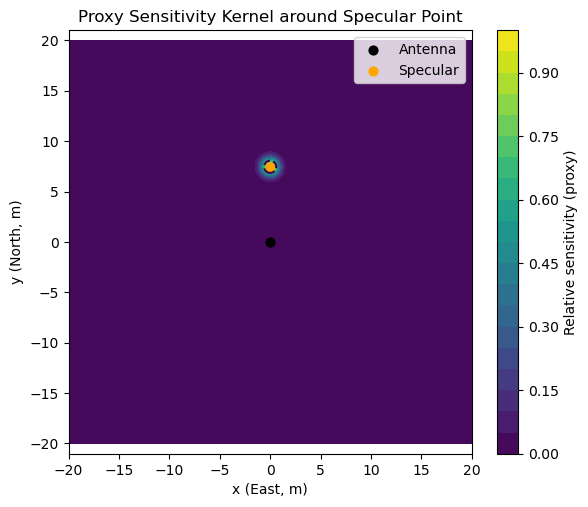

In [5]:

def gaussian_kernel(x, y, x0, y0, sigma):
    r2 = (x-x0)**2 + (y-y0)**2
    return np.exp(-0.5 * r2 / sigma**2)

# Grid for visualization
L = 20.0
N = 301
x = np.linspace(-L, L, N)
y = np.linspace(-L, L, N)
X, Y = np.meshgrid(x, y)

sigma = r1 / np.sqrt(2.0)
W = gaussian_kernel(X, Y, xP, yP, sigma)

plt.figure(figsize=(6.5,5.5))
cs = plt.contourf(X, Y, W, levels=20)
plt.colorbar(cs, label='Relative sensitivity (proxy)')
plt.scatter(0, 0, s=40, color='k', label='Antenna')
plt.scatter(xP, yP, s=40, color='orange', label='Specular')
plt.contour(X, Y, W, levels=[np.exp(-0.5)], linestyles='--')  # ~1-sigma
plt.axis('equal')
plt.xlabel('x (East, m)')
plt.ylabel('y (North, m)')
plt.title('Proxy Sensitivity Kernel around Specular Point')
plt.legend()
plt.show()



## (Optional) Interactive Exploration

If `ipywidgets` is available, use sliders to change elevation, height, and wavelength band to see how the footprint changes.


In [6]:

try:
    import ipywidgets as widgets
    from ipywidgets import interact, FloatSlider, Dropdown
    
    def explore(h=2.0, E_deg=15.0, band='L1'):
        wl = {'L1': lambda_L1, 'L2': lambda_L2, 'L5': lambda_L5}[band]
        xP, yP, r_off = specular_point(h, E_deg, 0.0)
        r1 = r1_fresnel(h, E_deg, wl)
        L = max(20.0, 2.5*r1)
        N = 301
        x = np.linspace(-L, L, N)
        y = np.linspace(-L, L, N)
        X, Y = np.meshgrid(x, y)
        sigma = r1 / np.sqrt(2.0)
        W = np.exp(-0.5 * ((X-xP)**2 + (Y-yP)**2) / sigma**2)
        
        plt.figure(figsize=(6.5,5.5))
        cs = plt.contourf(X, Y, W, levels=20)
        plt.colorbar(cs, label='Relative sensitivity (proxy)')
        plt.scatter(0, 0, s=40, color='k', label='Antenna')
        plt.scatter(xP, yP, s=40, color='orange', label='Specular')
        plt.contour(X, Y, W, levels=[np.exp(-0.5)], linestyles='--')
        plt.axis('equal')
        plt.xlabel('x (East, m)')
        plt.ylabel('y (North, m)')
        plt.title(f'Footprint (h={h:.1f} m, E={E_deg:.1f}°, {band})')
        plt.legend()
        plt.show()
    
    interact(explore,
             h=FloatSlider(min=0.5, max=5.0, step=0.1, value=2.0),
             E_deg=FloatSlider(min=5.0, max=30.0, step=0.5, value=15.0),
             band=Dropdown(options=['L1','L2','L5'], value='L1'))
except Exception as e:
    print("ipywidgets not available or failed to render:", e)


interactive(children=(FloatSlider(value=2.0, description='h', max=5.0, min=0.5), FloatSlider(value=15.0, descr…


## Environmental Implications (Qualitative)

- **Snow depth**: As snow accumulates, the effective reflector height changes, shifting the oscillation frequency.
  Elevation‑dependent $r_1$ indicates the spatial averaging scale of the retrieval.
- **Soil moisture**: Increased moisture modifies dielectric constant and coherence; effective sensitivity is strongest near the specular point, within $\sim r_1$.
- **Water level**: Over calm water, coherence is high; over rough water/waves the usable footprint reduces (lower effective coherence).

In practice, you will:
1. Select an elevation window (e.g., 5°–25°) balancing SNR (coherence) vs. footprint size.
2. Fit frequency in $\sin E$-space (next modules) to estimate reflector height and its change.
3. Validate using in‑situ records or metadata (e.g., antenna height surveys, snow stakes, tide gauges).



## Exercises
1. **Scaling check:** For $h=1\,\mathrm{m}$ vs. $h=4\,\mathrm{m}$ at $E=15^\circ$ (L1), verify that $r_1$ scales by a factor of 2.
2. **Band comparison:** At fixed $h$ and $E$, compute $r_1$ for L1, L2, L5 and discuss differences.
3. **Elevation trade‑off:** Plot $r_1(E)$ for $E\in[5^\circ,30^\circ]$ and explain the implications for spatial averaging and coherence.
4. **Design question:** If you want a footprint radius $r_1 \approx 8\,\mathrm{m}$ at $E=12^\circ$ using L1, what antenna height $h$ would you target?



## Next Notebook
**`04_Reading_SNR.ipynb`** — We’ll pivot from geometry to data: reading SNR from the EarthScope APIand plotting SNR vs. elevation for multiple satellites.
